Successfully loaded audio with torchaudio
Sample rate: 44100
Shape: torch.Size([1, 132300])
Duration: 3.00 seconds


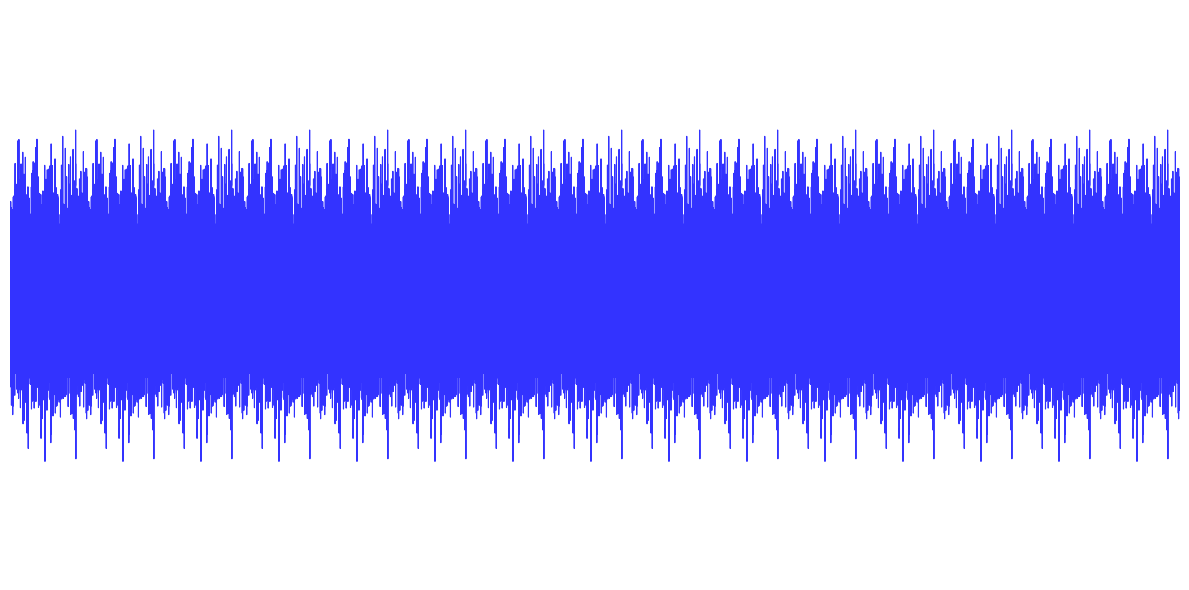


Audio Statistics:
Duration: 3.000 seconds
Sample rate: 44100 Hz
Number of samples: 132300
Min amplitude: -0.583862
Max amplitude: 0.578888
Mean amplitude: -0.000978
RMS amplitude: 0.184256
Standard deviation: 0.184253


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import librosa
import soundfile as sf
import os

# Path to the WAV file
wav_path = "/mnt/gestalt/home/buffett/EDM_FAC_FINAL_DATA/rendered_one_shot_flat/train/"
wav_path += "193_T617_CC3_best_flat_t2.64s.wav"


# Load the audio file using torchaudio
try:
    waveform, sample_rate = torchaudio.load(wav_path)
    length = 44100//5
    waveform = waveform[:, :length]
    waveform = waveform.repeat(1, 5*3)
    print(f"Successfully loaded audio with torchaudio")
    print(f"Sample rate: {sample_rate}")
    print(f"Shape: {waveform.shape}")
    print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")
except Exception as e:
    print(f"Error loading with torchaudio: {e}")
    # Try with librosa as fallback
    try:
        waveform, sample_rate = librosa.load(wav_path, sr=None)
        waveform = torch.from_numpy(waveform).unsqueeze(0)  # Add channel dimension
        print(f"Successfully loaded audio with librosa")
        print(f"Sample rate: {sample_rate}")
        print(f"Shape: {waveform.shape}")
        print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")
    except Exception as e2:
        print(f"Error loading with librosa: {e2}")
        # Try with soundfile as final fallback
        try:
            waveform, sample_rate = sf.read(wav_path)
            waveform = torch.from_numpy(waveform).unsqueeze(0)  # Add channel dimension
            print(f"Successfully loaded audio with soundfile")
            print(f"Sample rate: {sample_rate}")
            print(f"Shape: {waveform.shape}")
            print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")
        except Exception as e3:
            print(f"Error loading with soundfile: {e3}")
            print("Could not load the audio file with any method")
            
# Plot the loaded audio waveform
if 'waveform' in locals() and 'sample_rate' in locals():
    # Convert to numpy for plotting
    audio_data = waveform.squeeze().numpy()  # Remove channel dimension if mono
    duration = len(audio_data) / sample_rate
    time_axis = np.linspace(0, duration, len(audio_data))
    
    # Create single figure
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, audio_data, 'b-', linewidth=0.8, alpha=0.8)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, duration)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print audio statistics
    print(f"\nAudio Statistics:")
    print(f"Duration: {duration:.3f} seconds")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Number of samples: {len(audio_data)}")
    print(f"Min amplitude: {np.min(audio_data):.6f}")
    print(f"Max amplitude: {np.max(audio_data):.6f}")
    print(f"Mean amplitude: {np.mean(audio_data):.6f}")
    print(f"RMS amplitude: {np.sqrt(np.mean(audio_data**2)):.6f}")
    print(f"Standard deviation: {np.std(audio_data):.6f}")
    
else:
    print("No audio data loaded to plot")


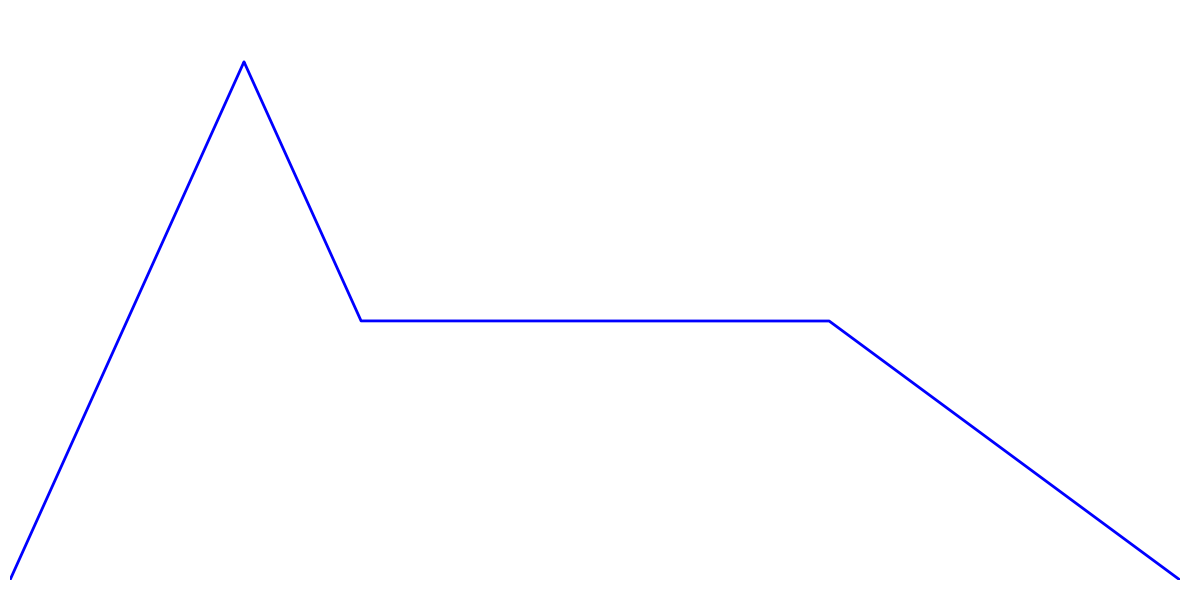

ADSR Parameters:
  Attack: 200.0 ms
  Hold: 0.0 ms
  Decay: 100.0 ms
  Sustain: 0.5
  Release: 300.0 ms

Total ADSR duration: 600.0 ms


In [15]:
midi_path = "/home/buffett/research/serum_render/midi/midi_files/evaluation/midi/101938.mid"

# plot ADSR
ADSR = {
    "attack": 200.0,
    "hold": 0.0,
    "decay": 100.0,
    "sustain": 0.5,
    "release": 300.0,
}

def generate_adsr_envelope(adsr_params, sample_rate=44100, note_duration=1.0):
    """
    Generate ADSR envelope
    
    Args:
        adsr_params: Dictionary with ADSR parameters
        sample_rate: Sample rate in Hz
        note_duration: Total note duration in seconds
    
    Returns:
        tuple: (time_axis, envelope)
    """
    # Convert times from ms to seconds
    attack_time = adsr_params["attack"] / 1000.0
    hold_time = adsr_params["hold"] / 1000.0
    decay_time = adsr_params["decay"] / 1000.0
    release_time = adsr_params["release"] / 1000.0
    sustain_level = adsr_params["sustain"]
    
    # Calculate total duration
    total_time = attack_time + hold_time + decay_time + release_time
    
    # If note duration is shorter than ADSR, scale it down
    if note_duration < total_time:
        scale_factor = note_duration / total_time
        attack_time *= scale_factor
        hold_time *= scale_factor
        decay_time *= scale_factor
        release_time *= scale_factor
        total_time = note_duration
    
    # Generate time axis
    num_samples = int(sample_rate * note_duration)
    time_axis = np.linspace(0, note_duration, num_samples)
    envelope = np.zeros(num_samples)
    
    # Calculate sample indices for each phase
    attack_samples = int(attack_time * sample_rate)
    hold_samples = int(hold_time * sample_rate)
    decay_samples = int(decay_time * sample_rate)
    release_samples = int(release_time * sample_rate)
    
    current_sample = 0
    
    # Attack phase (0 to 1)
    if attack_samples > 0:
        end_attack = min(current_sample + attack_samples, num_samples)
        attack_indices = slice(current_sample, end_attack)
        envelope[attack_indices] = np.linspace(0, 1, end_attack - current_sample)
        current_sample = end_attack
    
    # Hold phase (maintain at 1)
    if hold_samples > 0 and current_sample < num_samples:
        end_hold = min(current_sample + hold_samples, num_samples)
        hold_indices = slice(current_sample, end_hold)
        envelope[hold_indices] = 1.0
        current_sample = end_hold
    
    # Decay phase (1 to sustain level)
    if decay_samples > 0 and current_sample < num_samples:
        end_decay = min(current_sample + decay_samples, num_samples)
        decay_indices = slice(current_sample, end_decay)
        envelope[decay_indices] = np.linspace(1, sustain_level, end_decay - current_sample)
        current_sample = end_decay
    
    # Sustain phase (maintain at sustain level)
    sustain_start = current_sample
    sustain_end = num_samples - release_samples if release_samples > 0 else num_samples
    if sustain_start < sustain_end:
        sustain_indices = slice(sustain_start, sustain_end)
        envelope[sustain_indices] = sustain_level
        current_sample = sustain_end
    
    # Release phase (sustain level to 0)
    if release_samples > 0 and current_sample < num_samples:
        end_release = min(current_sample + release_samples, num_samples)
        release_indices = slice(current_sample, end_release)
        envelope[release_indices] = np.linspace(sustain_level, 0, end_release - current_sample)
    
    return time_axis, envelope

# Generate ADSR envelope
time_axis, adsr_envelope = generate_adsr_envelope(ADSR, sample_rate=44100, note_duration=1.0)

# Plot ADSR envelope
plt.figure(figsize=(12, 6))
plt.plot(time_axis * 1000, adsr_envelope, 'b-', linewidth=2)
# plt.title('ADSR Envelope')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)  # Show first 1000ms
plt.ylim(0, 1.1)

# Add phase labels
attack_end = ADSR["attack"]
hold_end = attack_end + ADSR["hold"]
decay_end = hold_end + ADSR["decay"]
release_end = decay_end + ADSR["release"]

# plt.axvline(x=attack_end, color='r', linestyle='--', alpha=0.5, label='Attack end')
# plt.axvline(x=hold_end, color='g', linestyle='--', alpha=0.5, label='Hold end')
# plt.axvline(x=decay_end, color='orange', linestyle='--', alpha=0.5, label='Decay end')
# plt.axvline(x=release_end, color='purple', linestyle='--', alpha=0.5, label='Release end')

# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

# Print ADSR parameters
print("ADSR Parameters:")
for key, value in ADSR.items():
    print(f"  {key.capitalize()}: {value} ms" if key != "sustain" else f"  {key.capitalize()}: {value}")
print(f"\nTotal ADSR duration: {sum([ADSR['attack'], ADSR['hold'], ADSR['decay'], ADSR['release']])} ms")

/home/buffett/research/serum_render/midi/midi_files/evaluation/midi/101938.mid


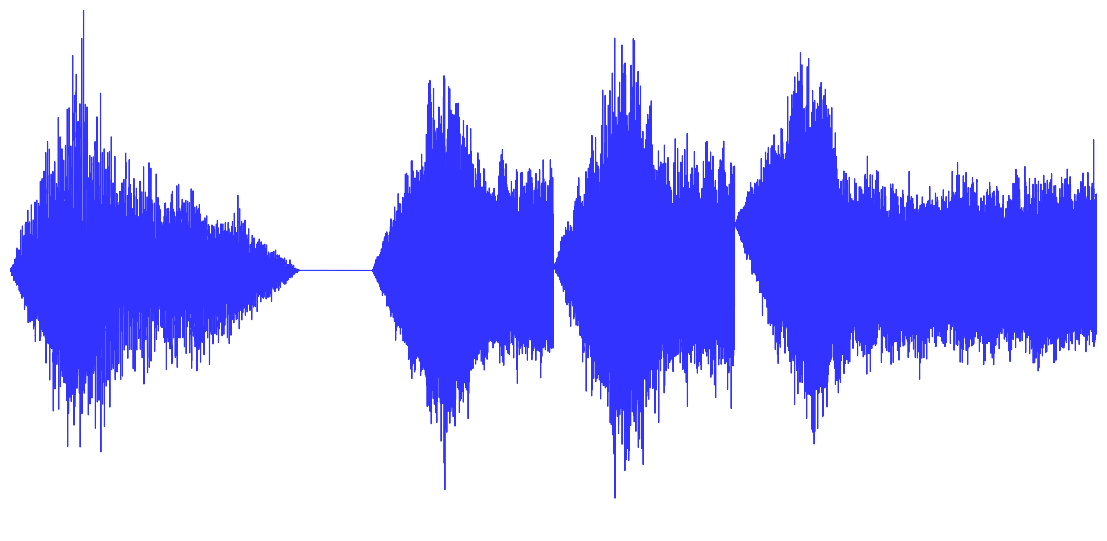

Rendered audio length: 132300 samples
Duration: 3.00 seconds
Max amplitude: 1.0000


In [16]:

import numpy as np
import pretty_midi
import librosa
from librosa.effects import pitch_shift

def simple_render_audio(waveform, midi_path, adsr_params, sample_rate=44100, reference_note=48):
    """
    Simple function to render audio from waveform, MIDI, and ADSR parameters
    
    Args:
        waveform: Audio waveform (numpy array)
        midi_path: Path to MIDI file
        adsr_params: Dictionary with 'attack', 'decay', 'sustain', 'release' (in ms)
        sample_rate: Sample rate (default: 44100)
        reference_note: Reference MIDI note for pitch shifting (default: 48 = C3)
    
    Returns:
        Rendered audio as numpy array
    """
    
    # Load MIDI file
    midi = pretty_midi.PrettyMIDI(midi_path)
    
    # Get the first instrument with notes
    instruments = [inst for inst in midi.instruments if inst.notes]
    if not instruments:
        return np.zeros(int(3 * sample_rate), dtype=np.float32)  # 3 seconds of silence
    
    inst = instruments[0]
    
    # Convert ADSR from ms to samples
    attack_samples = int(adsr_params['attack'] * sample_rate / 1000)
    decay_samples = int(adsr_params['decay'] * sample_rate / 1000)
    sustain_level = adsr_params['sustain']
    release_samples = int(adsr_params['release'] * sample_rate / 1000)
    
    # Create output buffer (3 seconds)
    total_samples = int(3 * sample_rate)
    output = np.zeros(total_samples, dtype=np.float32)
    
    # Process each note
    for note in inst.notes:
        if note.start >= 3.0:  # Skip notes beyond 3 seconds
            break
        if note.start == 0.5:
            continue
            
        # Calculate note timing in samples
        start_sample = int(note.start * sample_rate)
        note_duration = int((note.end - note.start) * sample_rate)
        
        # Pitch shift the waveform
        pitch_shift_steps = note.pitch - reference_note
        shifted_waveform = pitch_shift(waveform, sr=sample_rate, n_steps=pitch_shift_steps)
        
        # Create ADSR envelope
        total_env_samples = note_duration + release_samples
        envelope = np.zeros(total_env_samples, dtype=np.float32)
        
        # Attack phase (0 to 1)
        if attack_samples > 0:
            attack_end = min(attack_samples, total_env_samples)
            envelope[:attack_end] = np.linspace(0, 1, attack_end)
        
        # Decay phase (1 to sustain level)
        if decay_samples > 0 and attack_samples < total_env_samples:
            decay_start = attack_samples
            decay_end = min(decay_start + decay_samples, total_env_samples)
            if decay_end > decay_start:
                envelope[decay_start:decay_end] = np.linspace(1, sustain_level, decay_end - decay_start)
        
        # Sustain phase (sustain level)
        sustain_start = min(attack_samples + decay_samples, total_env_samples)
        sustain_end = min(sustain_start + (total_env_samples - sustain_start - release_samples), total_env_samples)
        if sustain_end > sustain_start:
            envelope[sustain_start:sustain_end] = sustain_level
        
        # Release phase (sustain to 0) - starts when note ends
        if release_samples > 0 and note_duration < total_env_samples:
            release_start = note_duration
            release_end = min(release_start + release_samples, total_env_samples)
            if release_end > release_start:
                envelope[release_start:release_end] = np.linspace(sustain_level, 0, release_end - release_start)
        
        # Apply envelope to waveform
        # 
        if note.start < 1:
            note_audio = shifted_waveform[:len(envelope)] * envelope[:len(shifted_waveform)]
        else:
            note_audio = shifted_waveform[:min(note_duration, len(shifted_waveform))] * envelope[:min(note_duration, len(shifted_waveform))]
        
        # Add to output buffer
        end_sample = min(start_sample + len(note_audio), total_samples)
        if end_sample > start_sample:
            output[start_sample:end_sample] += note_audio[:end_sample - start_sample]
        
        # Handle release phase
        if release_samples > 0 and note_duration < total_env_samples:
            release_start_sample = start_sample + note_duration
            release_end_sample = min(release_start_sample + release_samples, total_samples)
            if release_end_sample > release_start_sample:
                # Use last sample of shifted waveform for release
                release_timbre = np.full(release_end_sample - release_start_sample, 
                                       shifted_waveform[-1] if len(shifted_waveform) > 0 else 0)
                release_env = envelope[note_duration:note_duration + (release_end_sample - release_start_sample)]
                release_audio = release_timbre * release_env
                output[release_start_sample:release_end_sample] += release_audio
    
    # Normalize to prevent clipping
    max_amp = np.abs(output).max() + 1e-9
    output /= max_amp
    
    return output

# Example usage with your data
if 'waveform' in locals() and 'sample_rate' in locals():
    # Convert waveform to numpy if it's a torch tensor
    if hasattr(waveform, 'numpy'):
        waveform_np = waveform.squeeze().numpy()
    else:
        waveform_np = waveform
    
    # Render audio
    print(midi_path)
    rendered_audio = simple_render_audio(
        waveform=waveform_np,
        midi_path=midi_path,
        adsr_params=ADSR,
        sample_rate=sample_rate,
        reference_note=48  # C3
    )
    
    # Plot the rendered audio
    plt.figure(figsize=(12, 6))
    time_axis = np.linspace(0, len(rendered_audio) / sample_rate, len(rendered_audio))
    plt.plot(time_axis, rendered_audio, 'b-', linewidth=0.8, alpha=0.8)
    # plt.title('Rendered Audio with ADSR Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 3.0)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    
    print(f"Rendered audio length: {len(rendered_audio)} samples")
    print(f"Duration: {len(rendered_audio) / sample_rate:.2f} seconds")
    print(f"Max amplitude: {np.max(np.abs(rendered_audio)):.4f}")
    
else:
    print("Please run the previous cells to load waveform, midi_path, and ADSR data first")


/home/buffett/research/serum_render/midi/midi_files/evaluation/midi/101938.mid


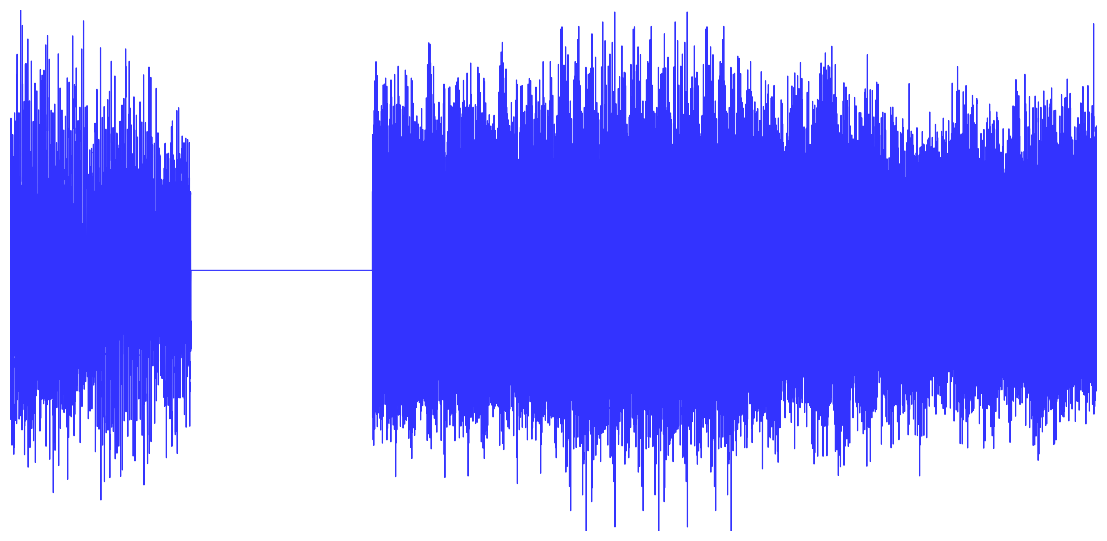

Rendered audio length: 132300 samples
Duration: 3.00 seconds
Max amplitude: 1.0000


In [17]:


import numpy as np
import pretty_midi
import librosa
from librosa.effects import pitch_shift

def simple_render_audio(waveform, midi_path, adsr_params, sample_rate=44100, reference_note=48):
    """
    Simple function to render audio from waveform, MIDI, and ADSR parameters
    
    Args:
        waveform: Audio waveform (numpy array)
        midi_path: Path to MIDI file
        adsr_params: Dictionary with 'attack', 'decay', 'sustain', 'release' (in ms)
        sample_rate: Sample rate (default: 44100)
        reference_note: Reference MIDI note for pitch shifting (default: 48 = C3)
    
    Returns:
        Rendered audio as numpy array
    """
    
    # Load MIDI file
    midi = pretty_midi.PrettyMIDI(midi_path)
    
    # Get the first instrument with notes
    instruments = [inst for inst in midi.instruments if inst.notes]
    if not instruments:
        return np.zeros(int(3 * sample_rate), dtype=np.float32)  # 3 seconds of silence
    
    inst = instruments[0]
    
    # Convert ADSR from ms to samples
    attack_samples = int(adsr_params['attack'] * sample_rate / 1000)
    decay_samples = int(adsr_params['decay'] * sample_rate / 1000)
    sustain_level = adsr_params['sustain']
    release_samples = int(adsr_params['release'] * sample_rate / 1000)
    
    # Create output buffer (3 seconds)
    total_samples = int(3 * sample_rate)
    output = np.zeros(total_samples, dtype=np.float32)
    
    # Process each note
    for note in inst.notes:
        if note.start >= 3.0:  # Skip notes beyond 3 seconds
            break
        if note.start == 0.5:
            continue
            
        # Calculate note timing in samples
        start_sample = int(note.start * sample_rate)
        note_duration = int((note.end - note.start) * sample_rate)
        
        # Pitch shift the waveform
        pitch_shift_steps = note.pitch - reference_note
        shifted_waveform = pitch_shift(waveform, sr=sample_rate, n_steps=pitch_shift_steps)
        
        # Apply waveform directly without ADSR envelope
        note_audio = shifted_waveform[:min(note_duration, len(shifted_waveform))]
        
        # Add to output buffer
        end_sample = min(start_sample + len(note_audio), total_samples)
        if end_sample > start_sample:
            output[start_sample:end_sample] += note_audio[:end_sample - start_sample]
        

    
    # Normalize to prevent clipping
    max_amp = np.abs(output).max() + 1e-9
    output /= max_amp
    
    return output

# Example usage with your data
if 'waveform' in locals() and 'sample_rate' in locals():
    # Convert waveform to numpy if it's a torch tensor
    if hasattr(waveform, 'numpy'):
        waveform_np = waveform.squeeze().numpy()
    else:
        waveform_np = waveform
    
    # Render audio
    print(midi_path)
    rendered_audio = simple_render_audio(
        waveform=waveform_np,
        midi_path=midi_path,
        adsr_params=ADSR,
        sample_rate=sample_rate,
        reference_note=48  # C3
    )
    
    # Plot the rendered audio
    plt.figure(figsize=(12, 6))
    time_axis = np.linspace(0, len(rendered_audio) / sample_rate, len(rendered_audio))
    plt.plot(time_axis, rendered_audio, 'b-', linewidth=0.8, alpha=0.8)
    # plt.title('Rendered Audio with ADSR Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 3.0)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    
    print(f"Rendered audio length: {len(rendered_audio)} samples")
    print(f"Duration: {len(rendered_audio) / sample_rate:.2f} seconds")
    print(f"Max amplitude: {np.max(np.abs(rendered_audio)):.4f}")
    
else:
    print("Please run the previous cells to load waveform, midi_path, and ADSR data first")


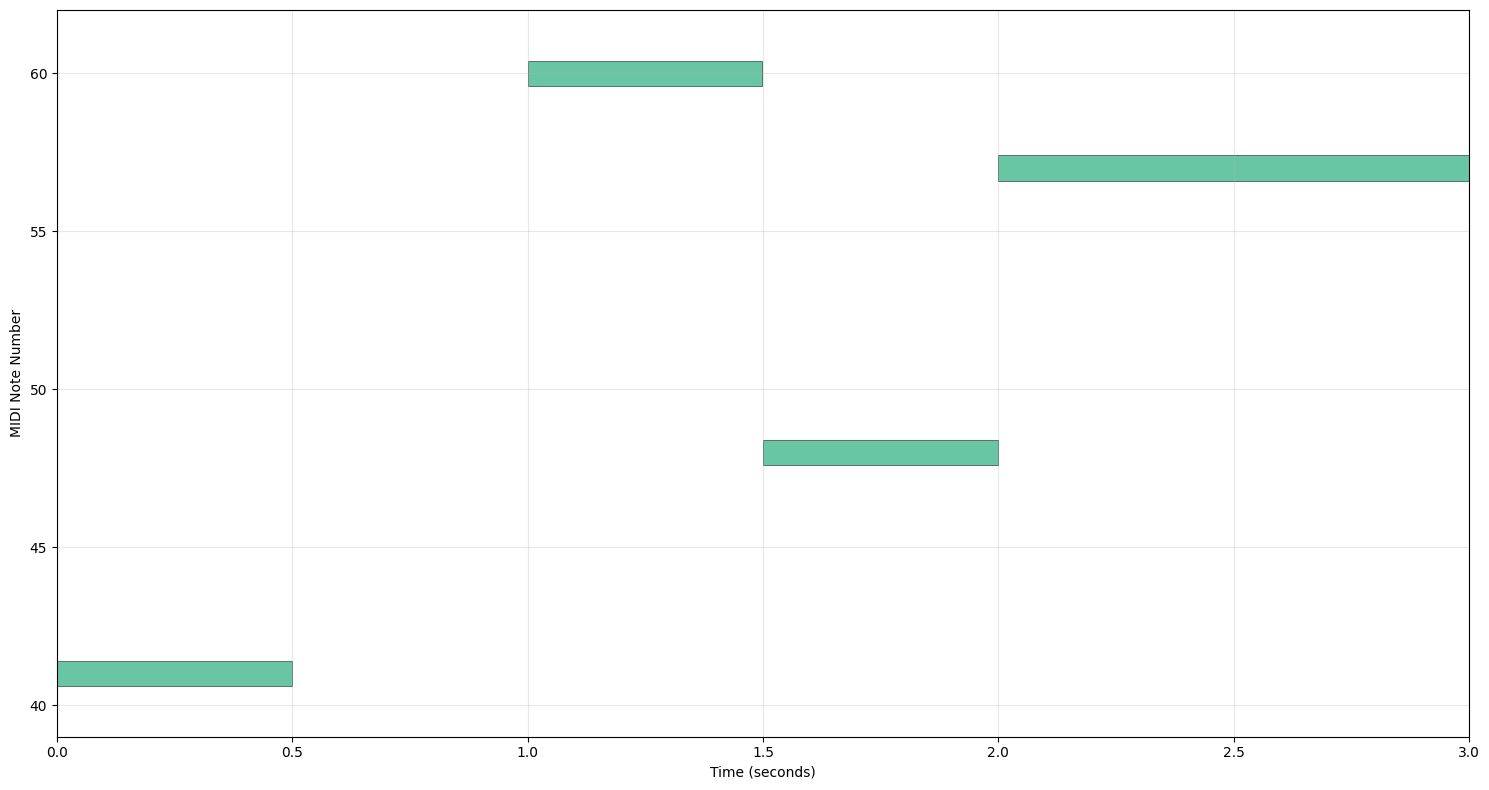

MIDI Statistics for 3.0 seconds:
Number of notes: 5
Note range: 41 - 60
Velocity range: 80 - 80
Average velocity: 80.0
Unique notes: [41, 45, 48, 57, 60]


In [12]:

import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

def plot_midi_3_seconds(midi_path, duration=3.0):
    """
    Plot MIDI file for 3 seconds
    
    Args:
        midi_path: Path to MIDI file
        duration: Duration to plot in seconds (default: 3.0)
    """
    # Load MIDI file
    midi = pretty_midi.PrettyMIDI(midi_path)
    
    # Get the first instrument with notes
    instruments = [inst for inst in midi.instruments if inst.notes]
    if not instruments:
        print("No notes found in MIDI file")
        return
    
    inst = instruments[0]
    
    # Filter notes within the duration
    notes_in_duration = [note for note in inst.notes if note.start < duration]
    
    if not notes_in_duration:
        print(f"No notes found within {duration} seconds")
        return
    
    # Create piano roll plot
    plt.figure(figsize=(15, 8))
    
    # Plot each note as a horizontal bar
    for i, note in enumerate(notes_in_duration):
        # Calculate note duration (capped at the plot duration)
        if note.start == 0.5:
            continue
        note_end = min(note.end, duration)
        note_duration = note_end - note.start
        
        # Plot the note
        plt.barh(note.pitch, note_duration, 
                left=note.start, height=0.8, 
                alpha=0.7, edgecolor='black', linewidth=0.5,
                color=plt.cm.viridis(note.velocity / 127.0))
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Note Number')
    # plt.title(f'MIDI Piano Roll - {duration} seconds')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, duration)
    
    # Set y-axis to show note range with some padding
    if notes_in_duration:
        note_range = max(note.pitch for note in notes_in_duration) - min(note.pitch for note in notes_in_duration)
        y_min = min(note.pitch for note in notes_in_duration) - 2
        y_max = max(note.pitch for note in notes_in_duration) + 2
        plt.ylim(y_min, y_max)
    
    # Add colorbar for velocity
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=127))
    sm.set_array([])
    # cbar = plt.colorbar(sm, ax=plt.gca())
    # cbar.set_label('Velocity')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"MIDI Statistics for {duration} seconds:")
    print(f"Number of notes: {len(notes_in_duration)}")
    print(f"Note range: {min(note.pitch for note in notes_in_duration)} - {max(note.pitch for note in notes_in_duration)}")
    print(f"Velocity range: {min(note.velocity for note in notes_in_duration)} - {max(note.velocity for note in notes_in_duration)}")
    print(f"Average velocity: {np.mean([note.velocity for note in notes_in_duration]):.1f}")
    
    # Show unique notes
    unique_notes = sorted(set(note.pitch for note in notes_in_duration))
    print(f"Unique notes: {unique_notes}")



# Plot the MIDI file for 3 seconds
midi_path = "/home/buffett/research/serum_render/midi/midi_files/evaluation/midi/101938.mid"
plot_midi_3_seconds(midi_path, duration=3.0)
